In [104]:
from pyemd import emd 
from sklearn.feature_extraction import stop_words
from scipy.optimize import curve_fit
from nltk.corpus import reuters
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.externals.joblib import Parallel, delayed
from sklearn import mixture
import seaborn as sns
from sklearn.preprocessing import normalize
import pickle
import random
from sklearn.neighbors import KNeighborsClassifier, BallTree
from sklearn.metrics import accuracy_score, classification_report
import gensim, math
import time
import pandas as pd
import nltk 
from os.path import dirname, abspath
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.corpus import stopwords
import lda
import numpy as np
import gensim
from nltk import word_tokenize
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import string
import os
from scipy.spatial.distance import cosine
from gensim.matutils import softcossim
from scipy.sparse import csc_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import mixture
from collections import Counter
import sklearn.metrics as mt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

figure(num=None, figsize=(10, 8), dpi=70, facecolor='w', edgecolor='k')

# Load word embeddings

In [2]:
def load_glove():    
    print("Loading Glove model")
    f = open('../Benchmark/glove.840B.300d.txt', errors = "ignore")
    glove = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            glove[word] = embedding
        except:
            pass
    print("Glove loading done.")
    return(glove)
def load_word2vec():
    print("Loading Word2vec model")
    word2vec = gensim.models.KeyedVectors.load_word2vec_format('../Benchmark/GoogleNews-vectors-negative300.bin', binary=True)
    print("Word2vec loading done")
    return word2vec
#glove = load_glove()
word2vec = load_word2vec()

Loading Word2vec model
Word2vec loading done


In [789]:
def tokenize_corpus(data):
    return [stoptokenizer(doc) for doc in data]
corpus = BBCSport.data
model = gensim.models.Word2Vec(
    tokenize_corpus(corpus),
    size=300,
    window=10,
    min_count=1,
    workers=4,
    sg = 1)
model.train(corpus, total_examples=len(corpus), epochs=300)
myvectors = model.wv
del model

# BBC news

In [3]:
class MyDataContainer(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    


def load_BBCNews(topics,folder):
    print("loading bbc news")
    tokenizer = CountVectorizer().build_analyzer()
    cwd = dirname(os.getcwd())+"/Data/"+folder
    BBCNews = MyDataContainer({'data': [],
               'target': []})
    index = 0
    for i, s in enumerate(topics):
        path = cwd+s
        ids = []
        for j, filename in enumerate(os.listdir(path)):
            ids.append(index)
            with open(path+"/"+filename, 'r', encoding="latin-1") as f:
                text = f.read() 
                #text = text+(" "+noises[noise_indices[counter]]+" ")*nn if add_noise else text
                BBCNews.data.append(text)
                BBCNews.target.append(i)
            f.close()
            index += 1 
        BBCNews[s] = ids
        print("{}: {} records".format(s, len(ids)))
    print("{} total records loaded".format(index))
    return BBCNews


topics_bbcnews = ["business", "entertainment", "politics", "sport", "tech"]
topics_bbcsport = ["athletics", "cricket","football","rugby","tennis"]
BBCNews = load_BBCNews(topics_bbcnews,"bbcnews/")
BBCSport = load_BBCNews(topics_bbcsport, "bbcsport/")

loading bbc news
business: 510 records
entertainment: 386 records
politics: 417 records
sport: 511 records
tech: 401 records
2225 total records loaded
loading bbc news
athletics: 101 records
cricket: 124 records
football: 265 records
rugby: 147 records
tennis: 100 records
737 total records loaded


# Mixed BBC news

# Reuters news

In [57]:
documents = reuters.fileids()
train_docs = list(filter(lambda doc: doc.startswith("train"),
                        documents));
test_docs = list(filter(lambda doc: doc.startswith("test"),
                       documents));
categories = reuters.categories();
category_docs = reuters.fileids("acq");

train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]


COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES SALE
  Computer Terminal Systems Inc said
  it has completed the sale of 200,000 shares of its common
  stock, and warrants to acquire an additional one mln shares, to
  &lt;Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs.
      The company said the warrants are exercisable for five
  years at a purchase price of .125 dlrs per share.
      Computer Terminal said Sedio also has the right to buy
  additional shares and increase its total holdings up to 40 pct
  of the Computer Terminal's outstanding common stock under
  certain circumstances involving change of control at the
  company.
      The company said if the conditions occur the warrants would
  be exercisable at a price equal to 75 pct of its common stock's
  market price at the time, not to exceed 1.50 dlrs per share.
      Computer Terminal also said it sold the technolgy rights to
  its Dot Matrix impact technology, including any future
  improvements, to &lt;Woodco Inc> of Hou

In [4]:
seeds_indices = random.sample(range(2225), 222)
noises = [BBCNews.data[t] for t in seeds_indices]
noises = " ".join(noises)
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space    
noises = noises.translate(translator).lower().split()
noises = list(set(noises))
noises = [t for t in noises if t in word2vec]

# 20 news

In [4]:
topics_news20 = [#'comp.graphics',
        #'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware',
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'sci.crypt',
        #'sci.electronics',
        'sci.med']

news20_all = fetch_20newsgroups(categories=topics_news20)
news20_noise = random.sample(news20_all.data, len(BBCNews.data))
BBCNews_noised = MyDataContainer({"data": [a+b for a, b in zip(news20_noise, BBCNews.data)],
                            "label": BBCNews.label})
print(news20_all.target[0])

0


# 20 news mixed

In [6]:
#pickle.dump(texts, open("sample_texts.pickle", "wb"))
texts = pickle.load(open("sample_texts.pickle", "rb"))

0.0681236


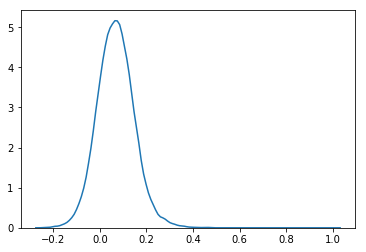

rectify, nets, quotation, nonshooting, passive, updated, observations, advantage, science, projection, compile, tens, downplayed, pales, sure, analyzed, urging, conceivable, cratered, weaken
[ 0.06687816  0.04504925]


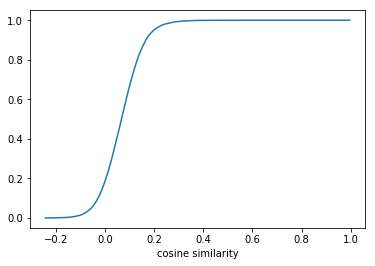

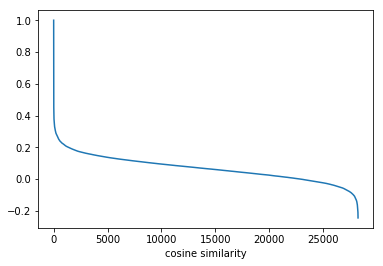

In [224]:
np.linalg.norm([1,2,3])
np.mean([[1,2,3],[1,2,3]], axis = 0)
vecs = np.array([[1,2,3], [1,3,4]])
tokenizer = CountVectorizer().build_analyzer()
stoptokenizer = CountVectorizer(stop_words = "english").build_analyzer()
def within_var(vecs):
    mean = np.mean(vecs, axis = 0)
    var = [np.sum(np.square(v-mean)) for v in vecs]
    return sum(var)
def within_std(vecs):
    mean = np.mean(vecs, axis = 0)
    var = [np.sqrt(np.sum(np.square(v-mean))) for v in vecs]
    var = np.sum(var)/len(var)
    return var

def within_cosine(vecs):
    if len(vecs) == 1:
        return 0
    mean = np.mean(vecs, axis = 0)
    similarity_matrix = cosine_similarity(vecs, [mean])
    return np.mean(similarity_matrix)
swords = tokenizer(" ".join(news20_all.data[:]))#stop_words.ENGLISH_STOP_WORDS#stopwords.words("english")
swords = [t for t in swords if t in word2vec]

s_vecs = [word2vec[t] for t in swords if t in word2vec]
stopwords_mean = np.mean(s_vecs, axis = 0)
stopwords_mean = word2vec["the"]
x = list(set(swords))
x_vecs = [word2vec[t] for t in x]
#stopwords_mean = word2vec["the"]
dist = cosine_similarity(x_vecs, [stopwords_mean])
dist = dist.ravel()
res = zip(dist, x)
sort_res = sorted(res,key=lambda res:res[0], reverse=True)
flags = np.array([1 for i in range(len(x))])

sorted_score = np.array([s for s, _ in sort_res])
sorted_words = np.array([w for _, w in sort_res])
print(np.mean(sorted_score))
sns.kdeplot(sorted_score)
plt.show()

ix = [i for i, score in enumerate(sorted_score) if  score>0.1]
thosewords = [sorted_words[i] for i in ix]
samplewords = random.sample(thosewords, 20)
print(", ".join(samplewords))
#print(sort_res)

percents = []
bins = []
xr = np.arange(min(sorted_score), max(sorted_score),0.01)
for thresh in xr:
    count = sum(sorted_score<=thresh)
    sc = 0 if count == 0 else count/len(x)
    percents.append(sc)
    bins.append(count-sum(sorted_score<=thresh-0.01))
bins = bins/sum(bins)

popt, pcov = curve_fit(logistic, xr, percents)
print(popt)
#plt.plot(xr, percents)
#plt.xlabel("cosine similarity")
#plt.ylabel(r"$\alpha$")
#plt.show()
#print([w for s,w in sort_res if s > 0.65 and w in swords])
#df = pd.DataFrame(dict(x = np.arange(0,1,0.005), score=percents))

#sns.lmplot("x",'score', data=df, fit_reg=False)
plt.plot(xr, percents)
plt.xlabel("cosine similarity")
#plt.ylabel(r"$\alpha$")
plt.show()
plt.plot(range(1,len(sorted_words)+1), sorted_score)
plt.xlabel("cosine similarity")
plt.ylabel("")
plt.show()
#for x in res: print(x)
#stopwords.words("english")+x
#for w, s in zip(dist, x):
    #print("{:.5f} {}".format(w, s))
def importance(words):
    vecs = [word2vec[word] for word in words]
    scores = cosine_similarity(vecs, [stopwords_mean]).ravel()
    print(scores)
    return [1/(1+np.exp(15.19*(score-0.42987))) for score in scores]    


0.0619121


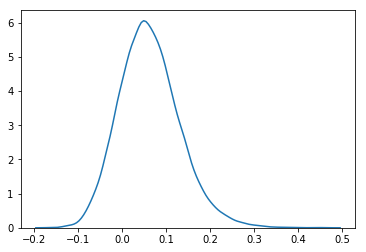

['after' 'factory' 'recently' 'headquarters' 'meanwhile' 'ago' 'whistle'
 'billboard' 'during']


In [172]:
#stopwords_mean = word2vec["stratify"]
#stopwords_mean = np.mean(s_vecs, axis = 0)
x = list(set(swords))
x_vecs = [word2vec[t] for t in x]
#stopwords_mean = word2vec["the"]
dist = cosine_similarity(x_vecs, [stopwords_mean])
dist = dist.ravel()
res = zip(dist, x)
sort_res = sorted(res,key=lambda res:res[0], reverse=True)
flags = np.array([1 for i in range(len(x))])

sorted_score = np.array([s for s, _ in sort_res])
sorted_words = np.array([w for _, w in sort_res])
print(np.mean(sorted_score))
sns.kdeplot(sorted_score)
plt.show()
print(sorted_words[-1:-10:-1])

In [95]:
#swords = tokenizer(" ".join(BBCNews.data[:]))
##word_counter = Counter(swords)
#unique_text = list(word_counter.keys())
#word_counts = np.array(list(word_counter.values()))
#res1 = zip(word_counts, unique_text)
#sort_res1 = sorted(res1, key = lambda res:res[0], reverse = True)
#sorted_score1 = np.array([s for s, _ in sort_res1])
#sorted_words1 = np.array([w for _, w in sort_res1])
ix = [i for i, score in enumerate(sorted_score) if  score>-0.2 and score < -0.1]
thosewords = [sorted_words[i] for i in ix]
samplewords = random.sample(thosewords, 20)
print(", ".join(samplewords))

seagate, aamir, hoper, 3g, olivia, razr, forrester, agence, leroy, flamini, yeob, olivier, korn, energie, armani, abraham, carr, capt, madrid, micah


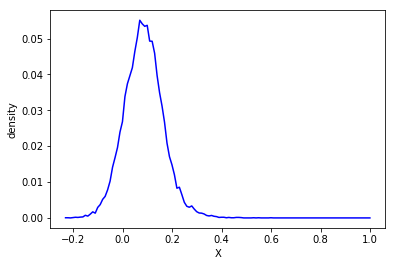

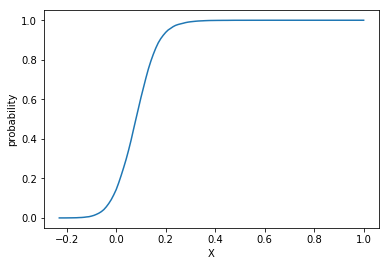

[-3.19755659  0.68458767]


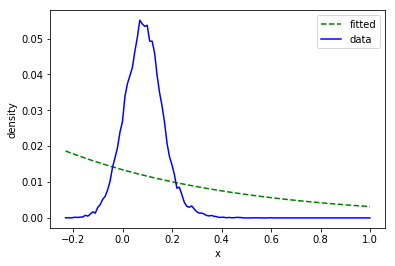

In [124]:
ix = [i for i, score in enumerate(sorted_score) if  score<0]
thosewords = [sorted_words[i] for i in ix]
samplewords = random.sample(thosewords, 10)
bins = []
xr = np.arange(min(sorted_score), max(sorted_score),0.01)
for thresh in xr:
    count = sum(sorted_score<=thresh) - sum(sorted_score < thresh-0.01)
    bins.append(count)
bins = bins/sum(bins)

plt.plot(xr, bins, color = "blue")
plt.xlabel("X")
plt.ylabel("density")
#plt.ylabel(r"$\alpha$")
plt.show()
plt.plot(xr, percents)
plt.xlabel("X")
plt.ylabel("probability")
plt.show()
popt, pcov = curve_fit(pdf_logistic, xr, bins)
print(popt)
plt.plot(xr, pdf_logistic(xr, *popt), 'g--', label='fitted')
plt.plot(xr, bins, 'b-', label='data')
plt.xlabel('x')
plt.ylabel("density")
plt.legend()
plt.show()

[ 0.06687816  0.04504925]


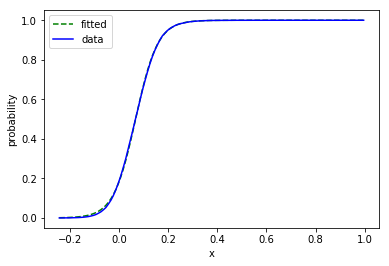

0.315560930812
[-3.21716937  0.68573259]


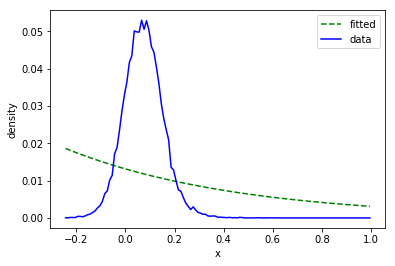

In [225]:
# samples = [w for s,w in sort_res if s < 0.2]
#print(max([b for a,b in zip(percents, xr )if a <= 0.5]))
#print(len(x))
##print(len(swords))
#print(len(samples))
#print(", ".join(random.sample(samples,30)))
def logistic(x, L,k,x0):
    
    return L/(1+np.exp(-k*(x-x0)))
def logistic(x, mu,s):
    return 1/(1+np.exp(-(x-mu)/s))

def importance_words(words):
    vecs = [word2vec[word] for word in words]
    scores = cosine_similarity(vecs, [stopwords_mean]).ravel()
    print(scores)
    #return [1/(1+np.exp(14.53*(score-0.40))) for score in scores]
    return [1/(1+np.exp(24*(score-0.16))) for score in scores]

def importance_vecs(vecs):
    scores = cosine_similarity(vecs, [stopwords_mean]).ravel()
    importances = [np.clip(1-1/(1+np.exp((0.066-score)/0.0444)),0,1) for score in scores]
    return sum(importances)/len(importances)
def pdf_logistic(x, mu, s):
    return np.exp((mu-x)/s)/(s*(1+np.exp((mu-x)/s))**2)
popt, pcov = curve_fit(logistic, xr, percents)
print(popt)
plt.plot(xr, logistic(xr, *popt), 'g--', label='fitted')
plt.plot(xr, percents, 'b-', label='data')
plt.xlabel('x')
plt.ylabel("probability")
plt.legend()
plt.show()
sample_lists = ["economics", "business", "sport", "entertainment", "tech"]
vecs = [word2vec[t] for t in sample_lists]
print(importance_vecs(vecs))
popt, pcov = curve_fit(pdf_logistic, xr, bins)
print(popt)
plt.plot(xr, pdf_logistic(xr, *popt), 'g--', label='fitted')
plt.plot(xr, bins, 'b-', label='data')
plt.xlabel('x')
plt.ylabel("density")
plt.legend()
plt.show()


Length of document: 319
# clusters: 6
# unique words: 171
[[ 0.99999994  0.04482901 -0.06475801 ...,  0.02697377 -0.01128015
  -0.05611101]
 [ 0.04482901  0.99999994  0.13105834 ...,  0.11758268  0.09972581
   0.14197892]
 [-0.06475801  0.13105834  1.00000012 ...,  0.00496626  0.05205137
   0.05324459]
 ..., 
 [ 0.02697377  0.11758268  0.00496626 ...,  1.          0.04814978
   0.07168648]
 [-0.01128015  0.09972581  0.05205137 ...,  0.04814978  1.          0.37159622]
 [-0.05611101  0.14197892  0.05324459 ...,  0.07168648  0.37159622  1.        ]]
[ 0.11346351  0.0174302   0.21708649  0.26431222  0.25222693  0.13548066]
label: 0
size: 41
weight: 0.11346350587652078
importance: 0.6402520422263598
nSize: 0.1453900709219858
however, still, concern, persistent, facing, uncertain, serious, threat, worrying, despite, risks, challenges, pressure, problems, faced, continue, face, slow, there, unlikely, sustain, warned, remain, relentless, inability, confidence, sufficiently, signs, slack, posi

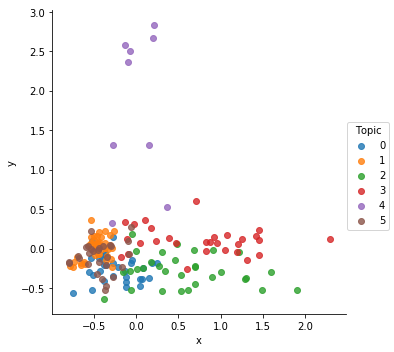

1013.48722714


In [40]:
doc = "Economics, economy, finance, capitalism, macroeconomics, money, consumer, euro, dollar, bank, rich, \
Dog, cat, goat, cow, horse,sheep, chicken, rabbit, fox,tiger,\
Red, orange, yellow, green,blue, purple, white, black,\
Football, basketball, baseball, tennis, swimming, archery,\
Denote, denotes, denotation,denoted, denoting, \
about, above, because, between, could, from, where,under, until, their, same, is, through, after, each,\
fashion, design, dressing, designer, stylish, artistic"
it1 = "Dog, cat, goat, cow, horse, sheep,chicken, rabbit, fox, tiger,\
Economics, economy, finance,capitalism, macroeconomics,money, consumer, euro, dollar,bank,\
Red, orange, yellow, green,blue, purple, white, black,pink, brown"

it2 = "Economics, economy, finance,capitalism, macroeconomics, money, consumer, euro, dollar,bank, rich,\
Dog, cat, goat, cow, horse,sheep, chicken, rabbit, fox, tiger,\
Red, orange, yellow, green,blue, purple, white, black,\
Football, basketball, baseball,tennis, swimming, archery,\
Denote, denotes, denotation,denoted, denoting,\
about, above, because, between,could, from, where, under,until, their, same, is,through, after, each, \
however, as, perhaps, therefore,\
fashion, design, dressing,designer, stylish, artistic"

it3 = "Blunkett hints at election call Ex-Home secretary David Blunkett has given fresh clues that the general election will be announced on Monday. He told BBC\
 Radio Five Live: I'm out in my constituency getting ready for what we presume will\
 be an announcement very shortly at the weekend. He clarified that he meant he would\
 be in his Sheffiled seat this weekend, not that he expected an election call then. \
 Tony Blair is tipped to ask the Queen on Monday to dissolve Parliament ready for a 5 \
 May poll."

it4 = "Lacroix label bought by US firm\
 Luxury goods group LVMH has sold its loss-making Christian Lacroix clothing label to a US investment group.\
 The Paris-based firm has been shedding non-core businesses and focusing on its most profitable brands including\
 Moet Chandon champagne and Louis Vuitton. LVMH said the French designer's haute couture and ready-to-wear labels\
 had been purchased by the Falic Group for an unspecified sum. The Falic Group bought two cosmetics labels from LVMH\
 in 2003. The sale of the Lacroix label comes as many fashion houses are struggling to make money from their expensive\
 haute couture ranges. The Florida-based Falic group, which also runs a chain of 90 duty free stores in the US, said\
 it planned to expand the brand by opening new stores. Mr Lacroix said he planned to stay at the label he founded in\
 1987 although exact details are still to be confirmed ."
swords_str = " ".join(stopwords.words("english"))
label1 = ["animals"]*10 + ["economics"]*10+["colors"]*10
label2 = ["economics"]*11+["animals"]*10+["colors"]*8+["sports"]*6+["variations"]*5 + ["stopwords"]*19 + ["fashion"]*6
wordembedding = word2vec
label = label1
def test( dataset, doc_id, synthetic, stop_words, n_clusters, loop, vis, unique,models, groundtruth):
    text = it2 if synthetic else dataset[doc_id]
    tokenizer = CountVectorizer(stop_words = "english").build_analyzer() if stop_words else CountVectorizer().build_analyzer() 
    text = tokenizer(text)
    
    print("Length of document: {}".format(len(text)))
    text = [t for t in text if t in wordembedding]
    word_counter = Counter(text)
    word_counts = np.array(list(word_counter.values()))
    unique_text = np.array(list(word_counter.keys()))
    vecs = np.array([wordembedding[w] for w in unique_text])
    num_clusters = n_clusters if n_clusters > 0 else math.floor(np.cbrt(len(unique_text)))
    print("# clusters: {}".format(num_clusters))
    print("# unique words: {}".format(len(vecs)))
    results_var = []
    results_sil = []
    results_cosine = []
    results_weights = []
    
    for model in models:
        var_sum = []
        sil_coef = []
        cosine_avg = []
        similarity_matrix = cosine_similarity(vecs)
        print(similarity_matrix)
        n_clusters_loop = range(2, num_clusters+1) if loop else range(num_clusters, num_clusters+1)
        for i in n_clusters_loop:
            if model == "kmeans":
                sc = KMeans(n_clusters = i, precompute_distances = True, 
                            n_init = 10, max_iter = 1000, algorithm = "full")
                sc.fit(vecs)
                distance_matrix =  cosine_distances(vecs)
                #var_sum.append(sc.inertia_)
            elif model == "spectral":
                sc = SpectralClustering(i, affinity='precomputed', 
                                        assign_labels = "discretize", 
                                        n_init=10)     
                sc.fit(similarity_matrix)
                distance_matrix = cosine_distances(vecs)
            elif model == "dbscan":
                sc = AgglomerativeClustering(
                                            n_clusters=i).fit(vecs)
                distance_matrix =  2-similarity_matrix
            elif model == "ggm":
                dpgmm = mixture.BayesianGaussianMixture(n_components=num_clusters, covariance_type='full').fit(vecs)
                sc.labels_ = dpgmm.predict(vecs)
                distance_matrix =  2-similarity_matrix
            
            #sc.labels = random.choices(range(num_clusters), k = len(vecs))
            silhoutte_scores = silhouette_samples(distance_matrix, sc.labels_, metric = 'precomputed')
            non_empty_clusters = np.array(list(set(sc.labels_)))
            indices = [np.where(sc.labels_ == j) if j in non_empty_clusters 
                                                               else [] for j in range(i)]
            sh_means = np.array([np.mean(silhoutte_scores[indices[j]]) for j in non_empty_clusters])
            sizes = [sum(word_counts[indices[j]]) for j in non_empty_clusters]
            weightings =np.array([ importance_vecs(vecs[indices[j]])*np.sqrt(sizes[j])  for j in non_empty_clusters])
            weightings = weightings/sum(weightings)
            print(weightings)
            sil_coef.append(np.mean(sh_means))
            if model == "spectral" or model == "kmeans":
                a = 0
            cosine_sum = 0
            weights = []
            for j in non_empty_clusters:
                if model == "spectral" or model == "kmeans":
                    a += within_var(vecs[indices[j]]) 
                words = unique_text[indices[j]].tolist()
                centroid = np.mean(vecs[indices[j]], axis = 0)
                dist = cosine_similarity(vecs[indices[j]], [centroid])
                res = zip(dist, words)
                sort_res = sorted(res,key=lambda res:res[0], reverse=True)
                words_sorted = [t for _, t in sort_res]
                myweight = weightings[j]
                weights.append(myweight)
                print("label: {}".format(j))
                print("size: {}".format(sizes[j]))
                print("weight: {}".format(myweight))
                print("importance: {}".format(importance_vecs(vecs[indices[j]])*np.sqrt(sizes[j])))
                print("nSize: {}".format(sizes[j]/sum(sizes)))
                #print(", ".join(words_sorted[:]))
                print(", ".join(words_sorted[:]))
                cosine_score = within_cosine(vecs[indices[j]])
                cosine_sum += cosine_score
            if model == "spectral" or model == "kmeans":
                var_sum.append(a)
            cosine_avg.append(cosine_sum/len(non_empty_clusters))
            if vis == "tsne":
                X_embedded = TSNE(n_iter = 1000,
                          metric = "precomputed").fit_transform(distance_matrix)
            else:
                X_embedded = decomposition.PCA(n_components=2, svd_solver = "full").fit_transform(vecs)
            df = pd.DataFrame(X_embedded)
            df['Topic'] = label if groundtruth else sc.labels_
            df.columns = ['x', 'y', 'Topic']
            #df.columns = ['x', 'y']
            sns.lmplot(x="x", y="y", hue = 'Topic', data=df, fit_reg=False, legend=True)
            #sns.lmplot(x="x", y="y", data=df, fit_reg=False)
            plt.show()
            #print("*"*20)
        results_var.append(var_sum)
        results_sil.append(sil_coef)
        #print(weights)
        results_weights.append(weights)
        results_cosine.append(cosine_avg)
        #print(distance_matrix)
        

    #print(text)
    #print(label)
    print(within_var(vecs))
    #print(sc.labels_.tolist())
    ##df['label'] = sc.labels_.tolist()
    #df.columns = ['x', 'y', 'label']
    #sns.lmplot(x="x", y="y", data=df, fit_reg=False, hue='label', legend=False)
    #plt.show()
    #x = loop
    ##plt.plot(x,results_var[0],linestyle="-.", color = "blue")
    #print(results_var[0])
    ##print(results_var[1])
    #plt.plot(x,results_var[1],linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, min(results_var[0]+ results_var[1]), max(results_var[0]+results_var[1])])
    #plt.ylabel('within-cluster sum-of-squares')
    #plt.xlabel('k')
    #plt.show()
    #plt.plot(x,results_sil[0], linestyle="-.", color = "blue")
    #plt.plot(x,results_sil[1], linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, -1, 1])
    #plt.ylabel('silhouttee coefficient')
    #plt.xlabel('k')
    ##plt.show()
    ##plt.plot(x,results_cosine[0], linestyle="-.", color = "blue")
    #plt.plot(x,results_cosine[1], linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, -1, 1])
    #plt.ylabel('cosine avg')
    #plt.xlabel('k')
    #plt.show()
    return distance_matrix
#k = -1500
k = 0
data = BBCNews
#test(news20_all.data, 38)
#print(data.topics[k])
#print(data.data[k])
distance_matrix = test(data.data, k, 
                       synthetic = False,
                       stop_words = False,
                      n_clusters = 6, 
                      loop = False, 
                      vis = "pca",
                      unique = False,
                      models = ["spectral"],
                      groundtruth = False)

### a = 

# Cluster-based wmd distance and soft cosine distance


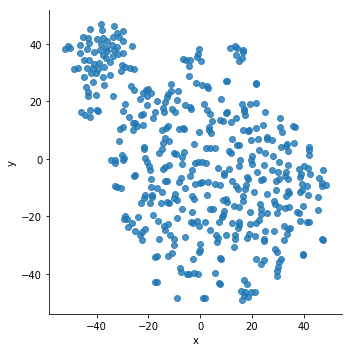

In [74]:
def test_vis(distance_matrix):
    X_embedded = TSNE(n_iter = 1000,
                      early_exaggeration = 10,
                      learning_rate = 900, 
                      method = "exact", 
                      metric = "precomputed").fit_transform(distance_matrix+0.000001)
    #X_embedded = decomposition.PCA(n_components=2).fit_transform(vecs)
    df = pd.DataFrame(X_embedded)
    #print(len(X_embedded))
    #df['label'] = sc.labels_
    df.columns = ['x', 'y']
    sns.lmplot(x="x", y="y",  data=df, fit_reg=False)
    plt.show()
test_vis(distance_matrix)

In [72]:
class PuncSplitTokenizer():
    """
        Map punctuations to space and then split, optional to remove predefined stopwords
    """
    def __init__(self, stopwords):
        __init__(self)
        self.stopwords = stopwords
    
    def __init__(self):
        self.translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
        self.stopwords = []
        
    def tokenize(self, text):
        tokens = text.translate(self.translator).lower().split()
        if self.stopwords:
            tokens = [t for t in tokens if t not in self.stopwords]
        return tokens

class TopicClusterGadget():
    """
        For vectorizing and computing document distance, based on word-topic-clusters in a document. 
        Implemented wmd_cosine, wmd_euclidean, and soft_cosine
    """
    def __init__(self, tokenizer, cls, distance_measure, word2vec, fixed_num_clusters):
        self.cls = cls
        self.tokenizer = tokenizer
        self.word2vec = word2vec
        self.distance_measure = distance_measure 
        self.fixed_num_clusters = fixed_num_clusters
        self.name = "{}+{}".format(cls, distance_measure)
        self.topics = []
        if distance_measure == "wmd_euclidean":
            self.get_distance = DistanceTool().wmd_distance_euclidean
        elif distance_measure == "wmd_cosine":
            self.get_distance = DistanceTool().wmd_distance_cosine
        elif self.distance_measure == "soft_cosine":
            self.get_distance = DistanceTool().softcosine_distance
        
    
    def tokenize(self, text):
        return self.tokenizer(text)
    
    def vectorize_all(self, train_X, test_X):
        train_vecs = [self.encode(t) for t in train_X]
        test_vecs = [self.encode(t) for t in test_X]
        max_len = np.max(np.concatenate(([len(a) for a in train_vecs], [len(a) for a in test_vecs])))
        train_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in train_vecs])
        test_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in test_vecs])
        return train_vecs, test_vecs
        
    def encode(self, text):
        text = self.tokenize(text)
        text = [t for t in text if t in self.word2vec]
        word_counter = Counter(text)
        word_counts = np.array(list(word_counter.values()))
        unique_text = np.array(list(word_counter.keys()))
        vecs = np.array([self.word2vec[w] for w in unique_text])
        num_clusters = math.floor(np.cbrt(len(unique_text))) if self.fixed_num_clusters <0 else self.fixed_num_clusters
                                
        if self.cls == "k-means": 
            model = KMeans(n_clusters = num_clusters, random_state=3425, precompute_distances = True)
            model.fit(vecs)
            distance_matrix = euclidean_distances(vecs)
            cluster_centers = model.cluster_centers_
            labels = model.labels_
        elif self.cls == "dsc":
            model = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=1)
            similarity_matrix = cosine_similarity(vecs).clip(0,1) 
            model.fit(similarity_matrix) 
            distance_matrix = 1-similarity_matrix
            labels = model.labels_
        elif self.cls == "random":
            labels = np.array(random.choices(range(num_clusters), k = len(vecs)))
        non_empty_clusters = np.array(list(set(labels))) 
        
        indices = [np.where(labels == i) if i in non_empty_clusters 
                                                           else [] for i in range(num_clusters)]
        
        if self.cls in ["dsc", "random"]:
            cluster_centers = np.array([np.mean(vecs[indices[i]], axis = 0) for i in non_empty_clusters])
        
        #sizes = np.array([sum(word_counts[indices[i]]) for i in non_empty_clusters])
        weights = [importance_vecs(vecs[indices[i]])*np.log2(sum(word_counts[indices[i]])) for i in non_empty_clusters]
        weights = weights/sum(weights)
        return np.concatenate([[len(non_empty_clusters)], cluster_centers.flatten(), weights])
    
    def decode(self, a, b):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        allTopics = np.concatenate([topics1,topics2])
        d1 = np.concatenate([weights1,[0]*len(topics2)])
        d2 = np.concatenate([[0]*len(topics1),weights2])
        return d1, d2, allTopics

class DistanceTool():
    """
        Implemented wmd_cosine, wmd_euclidean, and soft_cosine
    """
    def decode(self, a, b):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        allTopics = np.concatenate([topics1,topics2])
        d1 = np.concatenate([weights1,[0]*len(topics2)])
        d2 = np.concatenate([[0]*len(topics1),weights2])
        return d1, d2, allTopics
    
    def softcosine_distance(self, vec1, vec2):
        d1, d2, allTopics = self.decode(vec1, vec2)
        similarity_matrix = cosine_similarity(allTopics).clip(0,1)
        base1 = d1.dot(similarity_matrix)
        result = base1.dot(d2)
        vec1 = base1.dot(d1)
        vec2 = d2.dot(similarity_matrix).dot(d2)
        result /= (np.sqrt(vec1)*np.sqrt(vec2))
        return 1-result
    
    
    def wmd_distance_euclidean(self, vec1, vec2):
        return self.wmd_distance(vec1, vec2, euclidean_distances)
    
    def wmd_distance_cosine(self, vec1, vec2):
        return self.wmd_distance(vec1, vec2, cosine_distances)
    
    def wmd_distance(self, vec1, vec2, distance_func):
        d1, d2, allTopics = self.decode(vec1, vec2)
        distance_matrix = distance_func(allTopics, allTopics)
        return emd(d1, d2, distance_matrix)

class WordAverageGadget():
    """
        Averaging word vectors method
    """
    def __init__(self, tokenizer, word2vec, weighting):
        self.word2vec = word2vec
        self.tokenizer = tokenizer
        self.cls = "average"
        self.distance_measure = "word_average"
        self.weighting = weighting
        
    def tokenize(self, text):
        return self.tokenizer(text)
    
    def vectorize_all(self, train_X, test_X):
        train_X = [self.encode(t) for t in train_X]
        test_X = [self.encode(t) for t in test_X]
        return train_X, test_X
    
    def encode(self, text):
        text = self.tokenize(text)
        if self.weighting:
            vecs = np.array([self.word2vec[word] for word in text if word in self.word2vec])
            scores = cosine_similarity(vecs, [stopwords_mean]).ravel()
            importances = np.array([np.clip(1-1/(1+np.exp((0.1964-score)/0.0311)),0,1) for score in scores])
            weighted_vecs = [v*i for v, i in zip(vecs, importances)]
            return np.mean(weighted_vecs, axis = 0)
        else:
            vecs = [self.word2vec[w] for w in text if w in self.word2vec]
            return np.mean(vecs, axis=0)
    
    def decode(self):
        pass
        
class WordMoversDistanceGadget():
    """
        The original word mover's distance
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.cls = "none"
        self.distance_measure = "wmd"
        
    def tokenize(self, text):
        pass
    
    def vectorize_all(self, train_X, test_X):
        vec_all = CountVectorizer(stop_words="english").fit(train_X + test_X)
        common = [word for word in vec_all.get_feature_names() if word in self.word2vec]
        self.word2vec_common = [self.word2vec[t] for t in common]
        vect = CountVectorizer(vocabulary=common, dtype=np.double)
        train_X = normalize(vect.fit_transform(train_X), norm = 'l1', copy = False)
        test_X = normalize(vect.transform(test_X), norm = 'l1', copy = False)
        return train_X, test_X
    
    def get_distance(self, vec1, vec2):
        indices = np.union1d(vec1.indices, vec2.indices)
        vecs = [self.word2vec_common[i] for i in indices]
        distance_matrix = euclidean_distances(vecs)
        d1 = vec1[indices]
        d2 = vec2[indices]
        return emd(d1, d2, distance_matrix)
    
    def get_distance_matrix(self, train_vecs, test_vecs):
        #dist = [[self.get_distance(i, j)] for i, j in test_vecs, train_vecs]
        #dist = np.array([self.get_distance(i, j) for u, v in test_vecs, train_vecs])
        #dist = dist.reshape(len(test_vecs), -1)
        #dist = Parallel(n_jobs=1)(
         #   delayed(self.get_distance)(test_sample, train_vecs)
          #  for test_sample in test_vecs)
        return dist
    def encode(self):
        pass
    
    def decode(self):
        pass



# Benchmarking

In [227]:

def mix_bbcnews(topics, mixed_groups, BBC):
    #bbcnews: 2225
    print("mixing bbc news")
    min_size = min([len(BBC[topic]) for topic in topics])
    size = int(min_size/len(mixed_groups))
    print("#total samples: {}".format(len(BBC.data)))
    print("#samples per label: {}".format(size))
    BBC_mixed = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i, topic_group in enumerate(mixed_groups):    
        for j in range(size):
            #document_samples = [BBCNews.data[random.choice(BBCNews[topic])] for topic in topic_group]
            document_samples = [BBC.data[BBC[topic][int(i*size+j)]] for topic in topic_group]
            new_document = " ".join(document_samples)
            BBC_mixed.data.append(new_document)
            BBC_mixed.target.append(i)
            BBC_mixed.topics.append(topic_group)
        print("label: {}, topics: {}".format(i, topic_group))
    print("{} records loaded".format(len(BBC_mixed.data)))
    return BBC_mixed

def mix_news20(topics, mixed_ids, mixed_group):
    print("mixing 20 news")
    news20_all = fetch_20newsgroups(categories=topics)
    data_labels = [fetch_20newsgroups(categories=[topic]).data for topic in topics]
    min_size = min([len(data) for data in data_labels])
    #lens = [len(data) for data.data in data_labels]
    size = int(min_size/len(mixed_groups))
    print("#total samples:{}".format(len(news20_all.data)))
    print("#samples per label:{}".format(size))
    
    news20_mixed = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i, topicid_group in enumerate(mixed_ids):
        #group_samples = [fetch_20newsgroups(categories=[topic]) for topic in topic_group]
        
        for j in range(size):
            document_samples = [data_labels[iid][i*size+j] for iid in topicid_group]
            new_document = " ".join(document_samples)
            news20_mixed.data.append(new_document)
            news20_mixed.target.append(i)
            news20_mixed.topics.append(mixed_group[i])
        print("label: {}, topics: {}".format(i, mixed_group[i]))
    print("{} records loaded".format(len(news20_mixed.data)))
    return news20_all, news20_mixed
names_datasets = ["BBCSport_4", "BBCNews_4", "BBCNews_3", "BBCNews_2", "Newsgroup_4"]
topics_bbcsport = ["athletics", "cricket","football","rugby","tennis"]
topics = [topics_bbcsport[i] for i in [0,1,2,3,4]]
mixed_ids = [[0,1,2,3],
             [0,1,2,4],
             [0,1,3,4],
             [0,2,3,4],
             [1,2,3,4]]
mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]
BBCSport_mixed1 = mix_bbcnews(topics, mixed_groups, BBCSport)

topics_bbcnews = ["business", "entertainment", "politics", "sport", "tech"]    
topics = [topics_bbcnews[i] for i in [0,1,2,3,4]]
mixed_ids = [[0,1,2,3],
             [0,1,2,4],
             [0,1,3,4],
             [0,2,3,4],
             [1,2,3,4]]
mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]
BBCNews_mixed1 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics = [topics_bbcnews[i] for i in [1,2,3,4]]
mixed_ids = [[0,1,2],
             [0,1,3],
             [0,2,3],
             [1,2,3]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

BBCNews_mixed2 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics = [topics_bbcnews[i] for i in [0,1,4]]
mixed_ids = [[0,1],
             [0,2],
             [1,2]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

BBCNews_mixed3 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics_news20 = ['comp.sys.ibm.pc.hardware', 
              'rec.autos',
              'sci.space',
              'rec.sport.baseball',
              'sci.crypt',
              'sci.med',
              'talk.politics.guns']

topics = topics_news20

mixed_ids = [[0,1,2,3],
             [0,1,2,4],
             [0,1,3,4],
             [0,2,3,4],
             [1,2,3,4]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

news20_all, news20_mixed = mix_news20(topics, mixed_ids, mixed_groups)

mixing bbc news
#total samples: 737
#samples per label: 20
label: 0, topics: ['athletics', 'cricket', 'football', 'rugby']
label: 1, topics: ['athletics', 'cricket', 'football', 'tennis']
label: 2, topics: ['athletics', 'cricket', 'rugby', 'tennis']
label: 3, topics: ['athletics', 'football', 'rugby', 'tennis']
label: 4, topics: ['cricket', 'football', 'rugby', 'tennis']
100 records loaded
mixing bbc news
#total samples: 2225
#samples per label: 77
label: 0, topics: ['business', 'entertainment', 'politics', 'sport']
label: 1, topics: ['business', 'entertainment', 'politics', 'tech']
label: 2, topics: ['business', 'entertainment', 'sport', 'tech']
label: 3, topics: ['business', 'politics', 'sport', 'tech']
label: 4, topics: ['entertainment', 'politics', 'sport', 'tech']
385 records loaded
mixing bbc news
#total samples: 2225
#samples per label: 96
label: 0, topics: ['entertainment', 'politics', 'sport']
label: 1, topics: ['entertainment', 'politics', 'tech']
label: 2, topics: ['entertai

In [843]:

def create_subset(data, k):
    subset = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i in range(len(set(data.target))):
        targets = np.array(data.target)
        ids = np.where(targets == i)[0]
        sample_ids = random.choices(ids, k = k)
        print(sample_ids)
        sample_docs = [data.data[j] for j in sample_ids]
        subset.data.extend(sample_docs)
        subset.target.extend([i]*k)
        
        subset.topics.extend([data.topics[sample_ids[0]]]*k)
    return subset
BBCNews_mixed_sample = create_subset(BBCNews_mixed1, 10)
print(BBCNews_mixed1.topics[0])
print(len(BBCNews_mixed_sample.data))

[3, 31, 40, 61, 51, 87, 53, 48, 6, 17]
[100, 179, 185, 122, 175, 159, 179, 184, 108, 126]
[222, 212, 194, 255, 257, 201, 206, 229, 278, 235]
[330, 360, 366, 364, 328, 297, 332, 365, 374, 292]
['business', 'entertainment', 'politics']
40


In [ ]:
word_dic = word2vec
datasets = [BBCNews, BBCNews_mixed1, BBCNews_mixed2, BBCNews_mixed3, BBCSport_mixed1, news20_all]

stopwords_tokenizer = CountVectorizer(stop_words = "english").build_analyzer()
nostopwords_tokenizer = CountVectorizer().build_analyzer()
remove_stopwords = True
if remove_stopwords:
    tokenizerx = nostopwords_tokenizer
else:
    tokenizerx = nostopwords_tokenizer

#models = [WordMoversDistanceGadget(word_dic)]

mystopwords = "english" if remove_stopwords else None

bowVectorizer = make_pipeline(CountVectorizer(stop_words = mystopwords), 
                              Normalizer(norm = 'l1', copy = False)) 

tfidfVectorizer = make_pipeline(TfidfVectorizer(stop_words = mystopwords,use_idf = True),
                               Normalizer(norm = 'l1', copy = False))

BLmodels = [[bowVectorizer], [tfidfVectorizer]]

LDAmodels = [[make_pipeline(CountVectorizer(stop_words = mystopwords)
                              ,lda.LDA(n_topics=i, n_iter=100)) for i in range(13,33,3)]]

LSImodels = [[make_pipeline(CountVectorizer(stop_words = mystopwords), 
                                 Normalizer(norm = 'l1', copy = False), 
                                 TruncatedSVD(i)) for i in range(100,300,50)]]
WCDmodels = [WordAverageGadget(tokenizerx, word_dic, False),
            WordAverageGadget(tokenizerx, word_dic, True)]
n_k = -1
KMmodels = [[TopicClusterGadget(tokenizerx, "k-means", "wmd_euclidean", word_dic,n_k),
          TopicClusterGadget(tokenizerx, "k-means", "wmd_cosine", word_dic,n_k),
          TopicClusterGadget(tokenizerx, "k-means", "soft_cosine", word_dic,n_k)]]

DSCmodels = [[TopicClusterGadget(tokenizerx, "dsc", "wmd_euclidean", word_dic,n_k),
              TopicClusterGadget(tokenizerx, "dsc", "wmd_cosine", word_dic,n_k),
              TopicClusterGadget(tokenizerx, "dsc", "soft_cosine", word_dic,n_k)]]
classicals = ["BOW", "TF-IDF", "LSI", "LDA"]
WCDs = ["WCD_cosine", "WCD_euclidean", "WCD_I_cosine", "WCD_I_euclidean"]
KMs = ["kmeans_wmd_euclidean", "kmeans_wmd_cosine", "kmeans_soft_cosine"]
DSCs = ["dsc_wmd_euclidean", "dsc_wmd_cosine", "dsc_soft_cosine"]

k_values = range(10,18,2)
results_per_dataset=[]

for ds in datasets:
    accuracies = []
    train_X, test_X, train_y, test_y = train_test_split(ds.data, ds.target, test_size=0.5, 
                                                        shuffle = True, stratify = ds.target, random_state=42)
    
    cont_X, valid_X, cont_y, valid_y = train_test_split(train_X, train_y, test_size = 0.5, 
                                                        shuffle = True, random_state = 42, stratify = train_y)
    print("Training size:{}\n Test size:{}".format(len(train_X), len(test_X)))
    print("#Label: {}".format(len(set(train_y))))
    
    #print("Evaluating classical models...")
    for k in k_values: 
        k_accuracies = []
        
        print("fitting KNN for k = {}".format(k))
        for i, models in enumerate(BLmodels+LSImodels+LDAmodels): 
            print("fitting {}".format(classicals[i]))
            model_classification_reports = []
            max_accuracy = 0
            
            best_model = None
            max_accuracy = 0
            for model in models:
                cont_vecs = model.fit_transform(cont_X)
                valid_vecs = model.transform(valid_X)
                nbrs = KNeighborsClassifier(algorithm='brute', metric = "cosine", n_neighbors = k)
                nbrs.fit(cont_vecs, cont_y)
                prediction = nbrs.predict(valid_vecs)
                acc = accuracy_score(prediction, valid_y)
                if max_accuracy < acc:
                    print("find better")
                    best_model = model
                    best_tree = nbrs
                max_accuracy = acc
                #model_classification_reports.append(classification_report(test_y, prediction))
                #classification_reports.append(model_classification_reports)
            train_vecs = best_model.fit_transform(train_X)
            test_vecs = best_model.transform(test_X)
            best_tree.fit(train_vecs, train_y)
            prediction = best_tree.predict(test_vecs)
            acc = accuracy_score(prediction, test_y)
            print("accuracy: {}".format(acc))
            k_accuracies.append(acc)   
        
        for model in WCDmodels:
            for metric in ["cosine", "euclidean"]:
                print("fitting WCD {}".format(metric))
                train_vecs, test_vecs = model.vectorize_all(train_X, test_X)
                nbrs = KNeighborsClassifier(algorithm='brute', metric = metric, n_neighbors = k)
                nbrs.fit(train_vecs, train_y)
                print("predicting")
                prediction = nbrs.predict(test_vecs)
                acc = accuracy_score(prediction, test_y)
                print("accuracy: {}".format(acc))
                k_accuracies.append(acc)

        for names, models in zip([KMs]+[DSCs],KMmodels+DSCmodels):
            start = time.time()
            print("fitting {}".format(models[0].cls))
            train_vecs, test_vecs = models[0].vectorize_all(train_X, test_X)
            print("{}s for vectorization".format(time.time() - start))
            for i, model in enumerate(models):
                print("predicting {}".format(names[i]))
                start = time.time()
                nbrs = KNeighborsClassifier(algorithm='ball_tree', n_neighbors = k,
                                    metric=lambda a,b: model.get_distance(a, b))
                nbrs.fit(train_vecs, train_y)
                prediction = nbrs.predict(test_vecs)
                acc = accuracy_score(prediction, test_y)
                print("{}s for predicting".format(time.time()-start))
                print("accuracy: {}".format(acc))
                k_accuracies.append(acc)
        accuracies.append(k_accuracies)
    results_per_dataset.append(accuracies)
                

Training size:1112
 Test size:1113
#Label: 5
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.921832884097035
fitting TF-IDF
find better
accuracy: 0.9415992812219227
fitting LSI
find better
find better
find better
accuracy: 0.9209344115004492
fitting LDA
find better
find better
find better
accuracy: 0.949685534591195
fitting WCD cosine
predicting
accuracy: 0.9505840071877808
fitting WCD euclidean
predicting
accuracy: 0.954177897574124
fitting WCD cosine
predicting
accuracy: 0.9568733153638814
fitting WCD euclidean
predicting
accuracy: 0.954177897574124
fitting k-means


/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


117.66793298721313s for vectorization
predicting kmeans_wmd_euclidean
363.18324613571167s for predicting
accuracy: 0.903863432165319
predicting kmeans_wmd_cosine
464.04713106155396s for predicting
accuracy: 0.9191374663072777
predicting kmeans_soft_cosine
178.41708326339722s for predicting
accuracy: 0.9424977538185085
fitting dsc
35.16665077209473s for vectorization
predicting dsc_wmd_euclidean
372.39924812316895s for predicting
accuracy: 0.912848158131177
predicting dsc_wmd_cosine
474.5924129486084s for predicting
accuracy: 0.9407008086253369
predicting dsc_soft_cosine
181.8683099746704s for predicting
accuracy: 0.9523809523809523
fitting KNN for k = 12
fitting BOW
find better
accuracy: 0.9146451033243486
fitting TF-IDF
find better
accuracy: 0.945193171608266
fitting LSI
find better
find better
accuracy: 0.9326145552560647
fitting LDA
find better
find better
accuracy: 0.954177897574124
fitting WCD cosine
predicting
accuracy: 0.9514824797843666
fitting WCD euclidean
predicting
accuracy

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


121.03794407844543s for vectorization
predicting kmeans_wmd_euclidean
368.62139225006104s for predicting
accuracy: 0.9002695417789758
predicting kmeans_wmd_cosine
468.3804221153259s for predicting
accuracy: 0.921832884097035
predicting kmeans_soft_cosine
182.2647249698639s for predicting
accuracy: 0.9415992812219227
fitting dsc
36.84038591384888s for vectorization
predicting dsc_wmd_euclidean
371.5496208667755s for predicting
accuracy: 0.9110512129380054
predicting dsc_wmd_cosine
473.3923330307007s for predicting
accuracy: 0.9398023360287511
predicting dsc_soft_cosine
181.77299785614014s for predicting
accuracy: 0.9514824797843666
fitting KNN for k = 14
fitting BOW
find better
accuracy: 0.9065588499550764
fitting TF-IDF
find better
accuracy: 0.9460916442048517
fitting LSI
find better
find better
accuracy: 0.9245283018867925
fitting LDA
find better
find better
find better
find better
accuracy: 0.9559748427672956
fitting WCD cosine
predicting
accuracy: 0.9478885893980233
fitting WCD eucl

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


121.28202319145203s for vectorization
predicting kmeans_wmd_euclidean
367.89634108543396s for predicting
accuracy: 0.8966756513926325
predicting kmeans_wmd_cosine
469.3537087440491s for predicting
accuracy: 0.921832884097035
predicting kmeans_soft_cosine
183.04136085510254s for predicting
accuracy: 0.9407008086253369
fitting dsc
37.02335596084595s for vectorization
predicting dsc_wmd_euclidean
372.24384808540344s for predicting
accuracy: 0.9110512129380054
predicting dsc_wmd_cosine
473.9836940765381s for predicting
accuracy: 0.9389038634321654
predicting dsc_soft_cosine
182.42508220672607s for predicting
accuracy: 0.9514824797843666
fitting KNN for k = 16
fitting BOW
find better
accuracy: 0.9020664869721473
fitting TF-IDF
find better
accuracy: 0.9442946990116802
fitting LSI
find better
find better
accuracy: 0.9272237196765498
fitting LDA
find better
find better
find better
find better
accuracy: 0.9415992812219227
fitting WCD cosine
predicting
accuracy: 0.945193171608266
fitting WCD euc

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


121.09231996536255s for vectorization
predicting kmeans_wmd_euclidean
367.81547808647156s for predicting
accuracy: 0.8975741239892183
predicting kmeans_wmd_cosine
468.582643032074s for predicting
accuracy: 0.9200359389038635
predicting kmeans_soft_cosine
183.0627088546753s for predicting
accuracy: 0.9424977538185085
fitting dsc
37.45356488227844s for vectorization
predicting dsc_wmd_euclidean
371.348908662796s for predicting
accuracy: 0.9137466307277629
predicting dsc_wmd_cosine
472.9245991706848s for predicting
accuracy: 0.9380053908355795
predicting dsc_soft_cosine
183.16000509262085s for predicting
accuracy: 0.9523809523809523
Training size:192
 Test size:193
#Label: 5
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.3471502590673575
fitting TF-IDF
find better
accuracy: 0.43523316062176165
fitting LSI
find better
accuracy: 0.3471502590673575
fitting LDA
find better
find better
find better
find better
find better
accuracy: 0.29015544041450775
fitting WCD cosine
predicting
a

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


78.38714289665222s for vectorization
predicting kmeans_wmd_euclidean
16.473700761795044s for predicting
accuracy: 0.47668393782383417
predicting kmeans_wmd_cosine
19.570297956466675s for predicting
accuracy: 0.40932642487046633
predicting kmeans_soft_cosine
6.031517267227173s for predicting
accuracy: 0.5025906735751295
fitting dsc
23.40412187576294s for vectorization
predicting dsc_wmd_euclidean
16.18526005744934s for predicting
accuracy: 0.46632124352331605
predicting dsc_wmd_cosine
19.594853162765503s for predicting
accuracy: 0.5129533678756477
predicting dsc_soft_cosine
6.060362100601196s for predicting
accuracy: 0.6010362694300518
fitting KNN for k = 12
fitting BOW
find better
accuracy: 0.36787564766839376
fitting TF-IDF
find better
accuracy: 0.42487046632124353
fitting LSI
find better
accuracy: 0.34196891191709844
fitting LDA
find better
find better
find better
find better
accuracy: 0.33678756476683935
fitting WCD cosine
predicting
accuracy: 0.5544041450777202
fitting WCD euclidea

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


78.5523009300232s for vectorization
predicting kmeans_wmd_euclidean
16.51173186302185s for predicting
accuracy: 0.46632124352331605
predicting kmeans_wmd_cosine
19.68794298171997s for predicting
accuracy: 0.42487046632124353
predicting kmeans_soft_cosine
6.079176902770996s for predicting
accuracy: 0.5492227979274611
fitting dsc
23.015960931777954s for vectorization
predicting dsc_wmd_euclidean
16.1753351688385s for predicting
accuracy: 0.47668393782383417
predicting dsc_wmd_cosine
19.522417068481445s for predicting
accuracy: 0.5544041450777202
predicting dsc_soft_cosine
6.066906690597534s for predicting
accuracy: 0.6217616580310881
fitting KNN for k = 14
fitting BOW
find better
accuracy: 0.37305699481865284
fitting TF-IDF
find better
accuracy: 0.44559585492227977
fitting LSI
find better
accuracy: 0.3005181347150259
fitting LDA
find better
find better
find better
find better
accuracy: 0.35751295336787564
fitting WCD cosine
predicting
accuracy: 0.5854922279792746
fitting WCD euclidean
pr

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


78.53400087356567s for vectorization
predicting kmeans_wmd_euclidean
16.646313905715942s for predicting
accuracy: 0.47668393782383417
predicting kmeans_wmd_cosine
19.56891632080078s for predicting
accuracy: 0.46632124352331605
predicting kmeans_soft_cosine
6.017698049545288s for predicting
accuracy: 0.5181347150259067
fitting dsc
22.988866090774536s for vectorization
predicting dsc_wmd_euclidean
16.271140098571777s for predicting
accuracy: 0.47150259067357514
predicting dsc_wmd_cosine
19.515100955963135s for predicting
accuracy: 0.5595854922279793
predicting dsc_soft_cosine
6.083571910858154s for predicting
accuracy: 0.6269430051813472
fitting KNN for k = 16
fitting BOW
find better
accuracy: 0.38860103626943004
fitting TF-IDF
find better
accuracy: 0.43523316062176165
fitting LSI
find better
accuracy: 0.3160621761658031
fitting LDA
find better
find better
find better
accuracy: 0.30569948186528495
fitting WCD cosine
predicting
accuracy: 0.5544041450777202
fitting WCD euclidean
predicting

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


78.27689099311829s for vectorization
predicting kmeans_wmd_euclidean
16.451519012451172s for predicting
accuracy: 0.45595854922279794
predicting kmeans_wmd_cosine
19.608599185943604s for predicting
accuracy: 0.5077720207253886
predicting kmeans_soft_cosine
6.05919885635376s for predicting
accuracy: 0.49740932642487046
fitting dsc
23.193817853927612s for vectorization
predicting dsc_wmd_euclidean
16.18603491783142s for predicting
accuracy: 0.49740932642487046
predicting dsc_wmd_cosine
19.56874179840088s for predicting
accuracy: 0.5751295336787565
predicting dsc_soft_cosine
6.04161524772644s for predicting
accuracy: 0.6217616580310881
Training size:192
 Test size:192
#Label: 4
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.46875
fitting TF-IDF
find better
accuracy: 0.4895833333333333
fitting LSI
find better
accuracy: 0.4479166666666667
fitting LDA
find better
find better
find better
accuracy: 0.4895833333333333
fitting WCD cosine
predicting
accuracy: 0.671875
fitting WCD eucl

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


60.03472900390625s for vectorization
predicting kmeans_wmd_euclidean
15.09035587310791s for predicting
accuracy: 0.53125
predicting kmeans_wmd_cosine
18.217833995819092s for predicting
accuracy: 0.640625
predicting kmeans_soft_cosine
5.863896131515503s for predicting
accuracy: 0.71875
fitting dsc
16.455745935440063s for vectorization
predicting dsc_wmd_euclidean
14.927686929702759s for predicting
accuracy: 0.7239583333333334
predicting dsc_wmd_cosine
18.20653009414673s for predicting
accuracy: 0.7708333333333334
predicting dsc_soft_cosine
5.8444788455963135s for predicting
accuracy: 0.7708333333333334
fitting KNN for k = 12
fitting BOW
find better
accuracy: 0.4895833333333333
fitting TF-IDF
find better
accuracy: 0.4791666666666667
fitting LSI
find better
accuracy: 0.46875
fitting LDA
find better
find better
find better
find better
accuracy: 0.53125
fitting WCD cosine
predicting
accuracy: 0.6614583333333334
fitting WCD euclidean
predicting
accuracy: 0.6614583333333334
fitting WCD cosine

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


60.28231501579285s for vectorization
predicting kmeans_wmd_euclidean
15.112381219863892s for predicting
accuracy: 0.5052083333333334
predicting kmeans_wmd_cosine
18.309130907058716s for predicting
accuracy: 0.640625
predicting kmeans_soft_cosine
5.883544921875s for predicting
accuracy: 0.734375
fitting dsc
16.356931924819946s for vectorization
predicting dsc_wmd_euclidean
14.89064908027649s for predicting
accuracy: 0.7239583333333334
predicting dsc_wmd_cosine
18.180522918701172s for predicting
accuracy: 0.7708333333333334
predicting dsc_soft_cosine
5.87099289894104s for predicting
accuracy: 0.765625
fitting KNN for k = 14
fitting BOW
find better
accuracy: 0.453125
fitting TF-IDF
find better
accuracy: 0.46875
fitting LSI
find better
accuracy: 0.5
fitting LDA
find better
find better
find better
accuracy: 0.5104166666666666
fitting WCD cosine
predicting
accuracy: 0.671875
fitting WCD euclidean
predicting
accuracy: 0.6510416666666666
fitting WCD cosine
predicting
accuracy: 0.71354166666666

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


60.30553579330444s for vectorization
predicting kmeans_wmd_euclidean
15.049901962280273s for predicting
accuracy: 0.5208333333333334
predicting kmeans_wmd_cosine
18.230568170547485s for predicting
accuracy: 0.6770833333333334
predicting kmeans_soft_cosine
5.920183897018433s for predicting
accuracy: 0.7291666666666666
fitting dsc
16.726428270339966s for vectorization
predicting dsc_wmd_euclidean
14.872450113296509s for predicting
accuracy: 0.7083333333333334
predicting dsc_wmd_cosine
18.088659048080444s for predicting
accuracy: 0.7760416666666666
predicting dsc_soft_cosine
5.886656999588013s for predicting
accuracy: 0.7760416666666666
fitting KNN for k = 16
fitting BOW
find better
accuracy: 0.4739583333333333
fitting TF-IDF
find better
accuracy: 0.515625
fitting LSI
find better
accuracy: 0.4791666666666667
fitting LDA
find better
find better
find better
find better
find better
accuracy: 0.4479166666666667
fitting WCD cosine
predicting
accuracy: 0.671875
fitting WCD euclidean
predicting


/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


60.26377201080322s for vectorization
predicting kmeans_wmd_euclidean
15.062111139297485s for predicting
accuracy: 0.546875
predicting kmeans_wmd_cosine
18.200414180755615s for predicting
accuracy: 0.6614583333333334
predicting kmeans_soft_cosine
5.915706157684326s for predicting
accuracy: 0.7083333333333334
fitting dsc
16.94778609275818s for vectorization
predicting dsc_wmd_euclidean
14.939466953277588s for predicting
accuracy: 0.71875
predicting dsc_wmd_cosine
18.078733921051025s for predicting
accuracy: 0.7916666666666666
predicting dsc_soft_cosine
5.928477764129639s for predicting
accuracy: 0.7916666666666666
Training size:192
 Test size:192
#Label: 3
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.6979166666666666
fitting TF-IDF
find better
accuracy: 0.7291666666666666
fitting LSI
find better
accuracy: 0.6614583333333334
fitting LDA
find better
find better
find better
find better
accuracy: 0.7552083333333334
fitting WCD cosine
predicting
accuracy: 0.8697916666666666
fitt

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


40.43330788612366s for vectorization
predicting kmeans_wmd_euclidean
13.258000135421753s for predicting
accuracy: 0.7708333333333334
predicting kmeans_wmd_cosine
16.36553192138672s for predicting
accuracy: 0.8229166666666666
predicting kmeans_soft_cosine
5.6526079177856445s for predicting
accuracy: 0.8541666666666666
fitting dsc
10.866381883621216s for vectorization
predicting dsc_wmd_euclidean
13.205086946487427s for predicting
accuracy: 0.8802083333333334
predicting dsc_wmd_cosine
16.41374397277832s for predicting
accuracy: 0.8958333333333334
predicting dsc_soft_cosine
5.6785969734191895s for predicting
accuracy: 0.8958333333333334
fitting KNN for k = 12
fitting BOW
find better
accuracy: 0.7135416666666666
fitting TF-IDF
find better
accuracy: 0.7291666666666666
fitting LSI
find better
accuracy: 0.6614583333333334
fitting LDA
find better
find better
find better
find better
find better
accuracy: 0.7135416666666666
fitting WCD cosine
predicting
accuracy: 0.875
fitting WCD euclidean
pred

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


40.52470779418945s for vectorization
predicting kmeans_wmd_euclidean
13.279706716537476s for predicting
accuracy: 0.7604166666666666
predicting kmeans_wmd_cosine
16.48092484474182s for predicting
accuracy: 0.8333333333333334
predicting kmeans_soft_cosine
5.714595079421997s for predicting
accuracy: 0.8697916666666666
fitting dsc
11.062851905822754s for vectorization
predicting dsc_wmd_euclidean
13.286542177200317s for predicting
accuracy: 0.9010416666666666
predicting dsc_wmd_cosine
16.4013569355011s for predicting
accuracy: 0.9114583333333334
predicting dsc_soft_cosine
5.721696138381958s for predicting
accuracy: 0.890625
fitting KNN for k = 14
fitting BOW
find better
accuracy: 0.7552083333333334
fitting TF-IDF
find better
accuracy: 0.75
fitting LSI
find better
accuracy: 0.6458333333333334
fitting LDA
find better
find better
find better
find better
find better
find better
accuracy: 0.7239583333333334
fitting WCD cosine
predicting
accuracy: 0.859375
fitting WCD euclidean
predicting
accur

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


40.50630807876587s for vectorization
predicting kmeans_wmd_euclidean
13.2986319065094s for predicting
accuracy: 0.7760416666666666
predicting kmeans_wmd_cosine
16.34164786338806s for predicting
accuracy: 0.84375
predicting kmeans_soft_cosine
5.689809799194336s for predicting
accuracy: 0.859375
fitting dsc
10.977396965026855s for vectorization
predicting dsc_wmd_euclidean
13.203339099884033s for predicting
accuracy: 0.8802083333333334
predicting dsc_wmd_cosine
16.363982915878296s for predicting
accuracy: 0.9114583333333334
predicting dsc_soft_cosine
5.686000108718872s for predicting
accuracy: 0.890625
fitting KNN for k = 16
fitting BOW
find better
accuracy: 0.734375
fitting TF-IDF
find better
accuracy: 0.75
fitting LSI
find better
accuracy: 0.6614583333333334
fitting LDA
find better
find better
find better
find better
find better
accuracy: 0.6927083333333334
fitting WCD cosine
predicting
accuracy: 0.875
fitting WCD euclidean
predicting
accuracy: 0.8854166666666666
fitting WCD cosine
pre

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


40.59142994880676s for vectorization
predicting kmeans_wmd_euclidean
13.301558017730713s for predicting
accuracy: 0.796875
predicting kmeans_wmd_cosine
16.374682903289795s for predicting
accuracy: 0.8177083333333334
predicting kmeans_soft_cosine
5.729715824127197s for predicting
accuracy: 0.8541666666666666
fitting dsc
10.97129487991333s for vectorization
predicting dsc_wmd_euclidean
13.252301931381226s for predicting
accuracy: 0.8854166666666666
predicting dsc_wmd_cosine
16.43715000152588s for predicting
accuracy: 0.9114583333333334
predicting dsc_soft_cosine
5.6566150188446045s for predicting
accuracy: 0.890625
Training size:50
 Test size:50
#Label: 5
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.44
fitting TF-IDF
find better
accuracy: 0.52
fitting LSI
find better
accuracy: 0.44
fitting LDA
find better
find better
find better
find better
accuracy: 0.26
fitting WCD cosine
predicting
accuracy: 0.42
fitting WCD euclidean
predicting
accuracy: 0.42
fitting WCD cosine
predicti

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


15.392665147781372s for vectorization
predicting kmeans_wmd_euclidean
1.0394890308380127s for predicting
accuracy: 0.3
predicting kmeans_wmd_cosine
1.2602779865264893s for predicting
accuracy: 0.26
predicting kmeans_soft_cosine
0.4112708568572998s for predicting
accuracy: 0.34
fitting dsc
4.408151626586914s for vectorization
predicting dsc_wmd_euclidean
1.032353162765503s for predicting
accuracy: 0.36
predicting dsc_wmd_cosine
1.218837022781372s for predicting
accuracy: 0.32
predicting dsc_soft_cosine
0.38959312438964844s for predicting
accuracy: 0.34
fitting KNN for k = 12
fitting BOW
find better
accuracy: 0.4
fitting TF-IDF
find better
accuracy: 0.44
fitting LSI
find better
accuracy: 0.4
fitting LDA
find better
find better
accuracy: 0.24
fitting WCD cosine
predicting
accuracy: 0.38
fitting WCD euclidean
predicting
accuracy: 0.4
fitting WCD cosine
predicting
accuracy: 0.3
fitting WCD euclidean
predicting
accuracy: 0.32
fitting k-means


/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


15.442248821258545s for vectorization
predicting kmeans_wmd_euclidean
1.0230441093444824s for predicting
accuracy: 0.26
predicting kmeans_wmd_cosine
1.2185540199279785s for predicting
accuracy: 0.34
predicting kmeans_soft_cosine
0.40195775032043457s for predicting
accuracy: 0.36
fitting dsc
4.568088054656982s for vectorization
predicting dsc_wmd_euclidean
1.0422279834747314s for predicting
accuracy: 0.36
predicting dsc_wmd_cosine
1.280608892440796s for predicting
accuracy: 0.34
predicting dsc_soft_cosine
0.43053507804870605s for predicting
accuracy: 0.36
fitting KNN for k = 14
fitting BOW
find better
accuracy: 0.5
fitting TF-IDF
find better
accuracy: 0.42
fitting LSI
find better
accuracy: 0.5
fitting LDA
find better
find better
find better
find better
accuracy: 0.16
fitting WCD cosine
predicting
accuracy: 0.32
fitting WCD euclidean
predicting
accuracy: 0.28
fitting WCD cosine
predicting
accuracy: 0.32
fitting WCD euclidean
predicting
accuracy: 0.32
fitting k-means


/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


15.453588962554932s for vectorization
predicting kmeans_wmd_euclidean
1.0413298606872559s for predicting
accuracy: 0.26
predicting kmeans_wmd_cosine
1.2613000869750977s for predicting
accuracy: 0.28
predicting kmeans_soft_cosine
0.38898396492004395s for predicting
accuracy: 0.38
fitting dsc
4.52531886100769s for vectorization
predicting dsc_wmd_euclidean
1.0115892887115479s for predicting
accuracy: 0.42
predicting dsc_wmd_cosine
1.2150969505310059s for predicting
accuracy: 0.36
predicting dsc_soft_cosine
0.40214085578918457s for predicting
accuracy: 0.4
fitting KNN for k = 16
fitting BOW
find better
accuracy: 0.46
fitting TF-IDF
find better
accuracy: 0.44
fitting LSI
find better
accuracy: 0.46
fitting LDA
find better
find better
find better
accuracy: 0.26
fitting WCD cosine
predicting
accuracy: 0.3
fitting WCD euclidean
predicting
accuracy: 0.26
fitting WCD cosine
predicting
accuracy: 0.34
fitting WCD euclidean
predicting
accuracy: 0.26
fitting k-means


/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


15.431185007095337s for vectorization
predicting kmeans_wmd_euclidean
1.0200061798095703s for predicting
accuracy: 0.22
predicting kmeans_wmd_cosine
1.2353088855743408s for predicting
accuracy: 0.24
predicting kmeans_soft_cosine
0.41617298126220703s for predicting
accuracy: 0.36
fitting dsc
4.5315611362457275s for vectorization
predicting dsc_wmd_euclidean
1.0553369522094727s for predicting
accuracy: 0.4
predicting dsc_wmd_cosine
1.2806520462036133s for predicting
accuracy: 0.26
predicting dsc_soft_cosine
0.3910958766937256s for predicting
accuracy: 0.42
Training size:2054
 Test size:2055
#Label: 7
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.8350364963503649
fitting TF-IDF
find better
accuracy: 0.8875912408759125
fitting LSI
find better
find better
find better
find better
accuracy: 0.7927007299270074
fitting LDA
find better
find better
find better
find better
find better
accuracy: 0.8817518248175182
fitting WCD cosine
predicting
accuracy: 0.8618004866180049
fitting WCD e

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


172.36133885383606s for vectorization
predicting kmeans_wmd_euclidean
1089.8497512340546s for predicting
accuracy: 0.6754257907542579
predicting kmeans_wmd_cosine
1429.2494761943817s for predicting
accuracy: 0.7372262773722628
predicting kmeans_soft_cosine
607.4310040473938s for predicting
accuracy: 0.8175182481751825
fitting dsc
57.20836806297302s for vectorization
predicting dsc_wmd_euclidean
1122.3515717983246s for predicting
accuracy: 0.805352798053528
predicting dsc_wmd_cosine
1471.7667319774628s for predicting
accuracy: 0.8277372262773722
predicting dsc_soft_cosine
610.4150018692017s for predicting
accuracy: 0.8661800486618005
fitting KNN for k = 12
fitting BOW
find better
accuracy: 0.8287104622871047
fitting TF-IDF
find better
accuracy: 0.8885644768856448
fitting LSI
find better
find better
find better
find better
accuracy: 0.7936739659367397
fitting LDA
find better
find better
find better
find better
find better
find better
accuracy: 0.8763990267639903
fitting WCD cosine
predic

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


172.2927279472351s for vectorization
predicting kmeans_wmd_euclidean
1091.628702878952s for predicting
accuracy: 0.6720194647201947
predicting kmeans_wmd_cosine
1433.6022760868073s for predicting
accuracy: 0.7372262773722628
predicting kmeans_soft_cosine
609.017322063446s for predicting
accuracy: 0.808272506082725
fitting dsc
57.2577691078186s for vectorization
predicting dsc_wmd_euclidean
1121.0875458717346s for predicting
accuracy: 0.805352798053528
predicting dsc_wmd_cosine
1465.3452398777008s for predicting
accuracy: 0.8238442822384429
predicting dsc_soft_cosine
594.0405030250549s for predicting
accuracy: 0.8574209245742093
fitting KNN for k = 14
fitting BOW
find better
accuracy: 0.8228710462287104
fitting TF-IDF
find better
accuracy: 0.8885644768856448
fitting LSI
find better
find better
find better
find better
accuracy: 0.7961070559610706
fitting LDA
find better
find better
find better
accuracy: 0.8914841849148418
fitting WCD cosine
predicting
accuracy: 0.8545012165450122
fitting

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


167.8376908302307s for vectorization
predicting kmeans_wmd_euclidean
1281.0387480258942s for predicting
accuracy: 0.6793187347931874
predicting kmeans_wmd_cosine
1425.3876490592957s for predicting
accuracy: 0.7381995133819952
predicting kmeans_soft_cosine
612.327691078186s for predicting
accuracy: 0.8077858880778589
fitting dsc
58.63932991027832s for vectorization
predicting dsc_wmd_euclidean
1111.3543491363525s for predicting
accuracy: 0.8009732360097324
predicting dsc_wmd_cosine
1464.445083141327s for predicting
accuracy: 0.8145985401459854
predicting dsc_soft_cosine
600.8100860118866s for predicting
accuracy: 0.8549878345498784
fitting KNN for k = 16
fitting BOW
find better
accuracy: 0.8204379562043795
fitting TF-IDF
find better
accuracy: 0.8929440389294404
fitting LSI
find better
find better
find better
find better
accuracy: 0.7980535279805353
fitting LDA
find better
find better
find better
find better
find better
accuracy: 0.8574209245742093
fitting WCD cosine
predicting
accuracy:

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


178.15860199928284s for vectorization
predicting kmeans_wmd_euclidean
1097.5801002979279s for predicting
accuracy: 0.6744525547445256
predicting kmeans_wmd_cosine
1516.5867848396301s for predicting
accuracy: 0.7425790754257907
predicting kmeans_soft_cosine


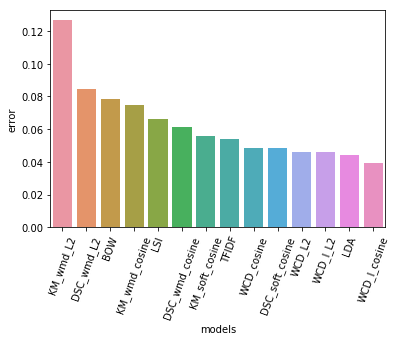

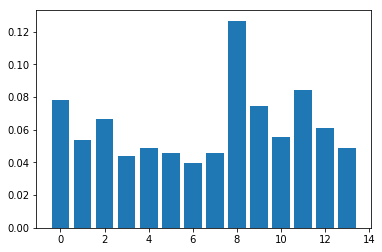

[0.92183288409703501, 0.94159928122192271, 0.92093441150044919, 0.95597484276729561, 0.9505840071877808, 0.95417789757412397, 0.95687331536388143, 0.95417789757412397, 0.87331536388140163, 0.92452830188679247, 0.94429469901168017, 0.91554357592093438, 0.93890386343216536, 0.9505840071877808]
[0.91464510332434856, 0.94519317160826599, 0.93351302785265045, 0.95238095238095233, 0.95148247978436662, 0.95327942497753815, 0.9604672057502246, 0.94968553459119498, 0.87151841868822999, 0.92362982929020665, 0.94159928122192271, 0.91284815813117703, 0.93261455525606474, 0.94788858939802334]
[0.90655884995507641, 0.9460916442048517, 0.92902066486972146, 0.94878706199460916, 0.94788858939802334, 0.94878706199460916, 0.95777178796046725, 0.9505840071877808, 0.86882300089847264, 0.92542677448337829, 0.94249775381850853, 0.91464510332434856, 0.93351302785265045, 0.95148247978436662]
[0.90206648697214731, 0.94429469901168017, 0.9308176100628931, 0.95148247978436662, 0.94519317160826599, 0.9469901168014

In [185]:
classicals = ["BOW", "TFIDF", "LSI", "LDA"]
WCDs = ["WCD_cosine", "WCD_L2", "WCD_I_cosine", "WCD_I_L2"]
KMs = ["KM_wmd_L2", "KM_wmd_cosine", "KM_soft_cosine"]
DSCs = ["DSC_wmd_L2", "DSC_wmd_cosine", "DSC_soft_cosine"]
names_datasets = ["BBCNews", "BBCNews_4", "BBCNews_3", "BBCNews_2","BBCSport_4", "Newsgroup_4"]
names = classicals+WCDs+KMs+DSCs
for i, result in enumerate(results_per_dataset):
    max_accuracies = 1-np.amax(result, axis = 0)
    #max_accuracies = max_accuracies
    zipped = zip(max_accuracies, names)
    sort =  sorted(zip(max_accuracies,names), reverse = True)
    sort_err = [e for e,_ in sort]
    sort_name = [n for _,n in sort]
    df = pd.DataFrame({"error": sort_err, "models": sort_name})
    ax = sns.barplot(x="models", y="error", data=df)
    plt.xticks(rotation=70)
    plt.title(names_datasets[i])
    plt.show()
    plt.bar(range(len(max_accuracies)),max_accuracies)

    plt.show()
for x in accuracies:
    print(x)
#for report in classification_reports:
 #   print(report[-1])
#for accuracy in accuraciesT:
 #   plt.bar(range(len(accuracy)), accuracy)
  #  plt.show()

In [41]:
train_X, test_X, train_y, test_y = train_test_split(BBCNews.data, BBCNews.label, test_size=0.3, random_state=42)
vec_all = CountVectorizer(stop_words="english").fit(train_X + test_X)
common = [word for word in vec_all.get_feature_names() if word in word2vec]
vect = CountVectorizer(vocabulary=common, dtype=np.double)
X_train = normalize(vect.fit_transform(train_X), norm = 'l1', copy = False)
X_test = vect.transform(test_X)

TypeError: 'NoneType' object is not subscriptable

In [42]:
0.82726423902894486, 0.86554621848739499, 0.86274509803921573, 
0.83660130718954251, 0.88982259570494859, 0.7796451914098973, 0.83846872082166202
print(X_train[0].indices)
print(common)
print(X_train[3].indices)
0.91616766467065869

NameError: name 'X_train' is not defined

In [47]:
a = [1,2,3,4]
a[[1,2,3]]

TypeError: list indices must be integers or slices, not list

In [ ]:
def wad(text):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    text = text.translate(translator).lower().split()
    text = [t for t in text if not t in stopwords.words("english")]
    return np.mean([word2vec[w] for w in text if w in word2vec], axis=0)

def wordcount(text):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    text = text.translate(translator).lower().split()
    text = [t for t in text if t in word2vec]
    return len(list(set(text)))
def build_vec_auto(text, cls, strategy):
    """build vector represenetation of text
        cls: Clustering model
        strategy: used with spectral clustering 
            0: non-empy clusters, positive silhoutte scores, weighted average
            1: 
    """
    x = text
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space    
    text = text.translate(translator).lower().split()
    start = time.time()
    text = [t for t in text if t in word2vec and not t in stopwords.words("english")]
    if cls == "kmeans":
        num_clusters = math.ceil(np.sqrt(len(set(text))))
        vecs = [word2vec[w] for w in text]
        km = KMeans(n_clusters = num_clusters, random_state=3425, precompute_distances = True)
        km.fit(vecs)
        non_empty_clusters = np.array(list(set(km.labels_)))
        indices = [np.where(sc.labels_ == i) if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
        
        sizes = np.array([sum(word_counts[indices[i]]) for i in non_empty_clusters])
        sizes_weights = sizes/sum(sizes)
        cluster_sizes = np.array([len(np.where(km.labels_ == i)[0]) for i in range(num_clusters)])
        weights = cluster_sizes/sum(cluster_sizes)
        
        return np.concatenate([[num_clusters], km.cluster_centers_.flatten(), weights])
    elif cls == "spectral":
        if strategy == 0:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = np.array(list(word_counter.values()))
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = math.ceil(np.sqrt(len(unique_text)))
            vecs = np.array([word2vec[w] for w in unique_text])
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            silhoutte_scores = silhouette_samples(2-similarity_matrix, sc.labels_, metric = 'precomputed')
            non_empty_clusters = np.array(list(set(sc.labels_)))
            indices = [np.where(sc.labels_ == i) if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            sh_means = np.array([np.mean(silhoutte_scores[indices[i]]) for i in non_empty_clusters])
            pos_sh_means_indices = np.where(sh_means > 0)
            sh_means = sh_means[pos_sh_means_indices]
            good_clusters = non_empty_clusters[pos_sh_means_indices]
            sh_weights = np.array(sh_means/sum(sh_means))
            
            sizes = np.array([sum(word_counts[indices[i]]) for i in good_clusters])
            sizes_weights = sizes/sum(sizes)
            p = 0.3
            weights = p*sh_weights+(1-p)*sizes_weights
            #print("{},{},{}".format(sum(sh_weights), sum(sizes_weights), sum(weights)))
            centroids = np.array([np.mean(vecs[indices[i]], axis = 0) for i in good_clusters])
            rep = np.concatenate(([len(good_clusters)], centroids.flatten(), sizes_weights))
            return rep
        elif strategy == 1:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = list(word_counter.values())
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = math.ceil(np.sqrt(len(unique_text)))
            vecs = [word2vec[w] for w in unique_text]
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            silhoutte_scores = silhouette_samples(2-similarity_matrix, sc.labels_, metric = 'precomputed')
            silhoutte_contribution = np.multiply(word_counts, silhoutte_scores)
            total_contribution = sum(silhoutte_contribution)
            non_empty_clusters = list(set(sc.labels_))
            indices = [np.where(sc.labels_ == i)[0].tolist() if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            
            weights = np.array([sum(np.take(silhoutte_contribution, indices[i]))/total_contribution
                                                                        for i in non_empty_clusters])
            #print("{},{},{}".format(sum(sh_weights), sum(sizes_weights), sum(final_weights)))
            centroids = np.array([np.mean(np.take(vecs, indices[i], axis = 0), axis = 0) for i in non_empty_clusters])
            rep = np.concatenate([[len(non_empty_clusters)], centroids.flatten(), weights])
            #for i in range(len(weights)):
             #   print(weights[i])
              #  print(np.take(unique_text, indices[non_empty_clusters[i]]))
            #print("-----")
            return rep
        elif strategy == 2:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = list(word_counter.values())
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = 10#math.ceil(np.sqrt(len(unique_text)))
            vecs = [word2vec[w] for w in unique_text]
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            non_empty_clusters = list(set(sc.labels_))
            indices = [np.where(sc.labels_ == i)[0].tolist() if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            sizes = np.array([sum(np.take(word_counts, indices[i])) for i in non_empty_clusters])
            centroids = np.array([np.mean(np.take(vecs, indices[i], axis = 0), axis = 0) for i in non_empty_clusters])
            rep = np.concatenate([[len(non_empty_clusters)], centroids.flatten(), [1/len(sizes)]*len(sizes)])
            return rep

def cluster_TSCD_auto(a, b):
    def euclidean(a, b):
        return np.sqrt(np.sum(np.square(a-b)))
    start = time.time()
    num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
    cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
    topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
    weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
    allTopics = np.concatenate([topics1,topics2])
    d1 = np.concatenate([weights1,[0]*len(topics2)])
    d2 = np.concatenate([[0]*len(topics1),weights2])
    similarity_matrix = cosine_similarity(allTopics)
    result = d1.T.dot(similarity_matrix).dot(d2)
    vec1 = d1.T.dot(similarity_matrix).dot(d1)
    vec2 = d2.T.dot(similarity_matrix).dot(d2)
    result /= (np.sqrt(vec1)*np.sqrt(vec2))
    #print(time.time()-start)
    return np.clip(1-result, 0 , 1)

def cluster_TSCD(a, b, num_clusters):
    def euclidean(a, b):
        return np.sqrt(np.sum(np.square(a-b)))
    cut = 300*num_clusters
    topics1, topics2 = a[0:cut].reshape(-1,300), b[0:cut].reshape(-1,300)
    freq1, freq2 = a[cut:], b[cut:]
    allTopics = np.concatenate([topics1,topics2])
    
    d1 = np.concatenate([freq1/sum(freq1),[0]*len(topics2)])
    d2 = np.concatenate([[0]*len(topics1),freq2/sum(freq2)])
    similarity_matrix = np.ones((len(allTopics), len(allTopics)), np.float64)
    for i in range(1, len(allTopics)):
        for j in range(i):
            #distance_matrix[i, j] = euclidean(allTopics[i], allTopics[j])
            similarity_matrix[i, j] = 1-cosine(allTopics[i], allTopics[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]
    result = d1.T.dot(similarity_matrix).dot(d2)
    vec1 = d1.T.dot(similarity_matrix).dot(d1)
    vec2 = d2.T.dot(similarity_matrix).dot(d2)
    result /= (np.sqrt(vec1)*np.sqrt(vec2))
    return np.clip(1-result, 0, 1)

def cluster_TSCD_raw(text1, text2, num_clusters):
    return cluster_TSCD(build_vec(text1, num_clusters), build_vec(text2, num_clusters), num_clusters)

def cluster_TSCD_raw_auto(text1, text2, cls, strategy):
    return cluster_TSCD_auto(build_vec_auto(text1, cls, strategy), build_vec_auto(text2, cls, strategy))

x = build_vec_auto(texts[-1], "spectral", 0)
x

In [ ]:
mydata = news20_all
train_X, test_X, train_y, test_y = train_test_split(mydata.data, mydata.target, test_size=0.3, random_state=42)
print("started KNN ")
start = time.time()
algo = "wad"
if algo == "wad":
    train_vecs = [ wad(t) for t in train_X]
    test_vecs = [ wad(t) for t in test_X]
elif algo == "LSA":
    LsaVectorizer = make_pipeline(TfidfVectorizer(max_features = 20000, use_idf = True, min_df=2)
                              ,TruncatedSVD(300))
    train_vecs = LsaVectorizer.fit_transform(train_X)
    test_vecs = LsaVectorizer.transform(test_X)
elif algo == "TSCD":
    train_vecs = [ build_vec_auto(t, 'kmeans', 2) for t in train_X]
    test_vecs = [ build_vec_auto(t, 'kmeans', 2) for t in test_X]
    max_len = np.max(np.concatenate(([len(a) for a in train_vecs], [len(a) for a in test_vecs])))
    train_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in train_vecs])
    test_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in test_vecs])
print(time.time() - start)
print("Vectorization finished")

In [ ]:
if algo != "TSCD":
    nbrs = GridSearchCV(KNeighborsClassifier(algorithm='ball_tree'), cv = None, 
                    param_grid={"n_neighbors": range(5,20,5)})
else:
    nbrs = KNeighborsClassifier(algorithm='ball_tree', n_neighbors = 10,
                                metric=lambda a,b: cluster_TSCD_auto(a, b))
nbrs.fit(train_vecs, train_y)
print(time.time() - start)
start = time.time()
#test_vecs = [build_vec(t, num_clusters) for t in news20_test.data]

print("started predicting")
start = time.time()
predicted = nbrs.predict(test_vecs)
print(accuracy_score(predicted, test_y))

In [319]:
print(BBCNews.data[0])
tokenizer = CountVectorizer().build_analyzer()
train = ["ing bank", "bbingbb bank", "lidl"]
test = ["domesti"]
def char_bulk_transformer(texts):
    return [" ".join(t).join(t.lower().split()) for t in texts]
train_trans = char_bulk_transformer(train)
test_trans = char_bulk_transformer(test)
print(train_trans)
INGDumper = make_pipeline(CountVectorizer(ngram_range =(1,4), analyzer = 'char', stop_words=None), 
                              Normalizer(norm = 'l1', copy = False), 
                              TruncatedSVD(20))
train_vecs = INGDumper.fit_transform(train_trans)
test_vecs = INGDumper.transform(test_trans)
tree = BallTree(train_vecs, leaf_size=2)              
dist, ind = tree.query(test_vecs, k=3) 
print(train[ind[0][0]])

UK economy facing 'major risks'

The UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.

The group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.

Manufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.

"Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sector's persistent inab

-0.88047579732
-0.814413231819


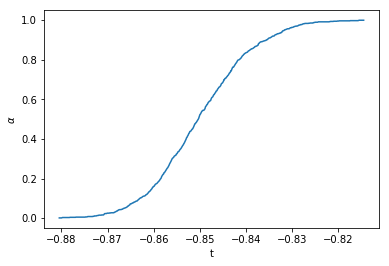

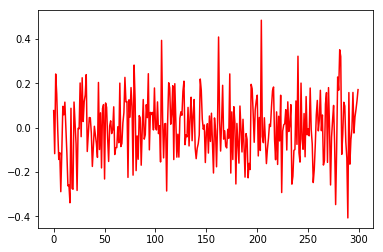

In [657]:
dimension = 300
x = [[random.uniform(-0.1,0) for j in range(dimension)] for i in range(1000)]
centroid =[random.uniform(0.1,0.2) for j in range(dimension)] 
dist = cosine_similarity(x, [centroid])
#dist = euclidean_distances(x, [centroid])
dist = dist.ravel()
#print(dist)
#dist = euclidean_distances(x_vecs, [mean])
res = zip(dist, x)
sort_res = sorted(res,key=lambda res:res[0], reverse=True)
flags = np.array([(t in x) for _, t in sort_res])
flags = np.array([1]*len(dist))
#print(flags)
#for x in sort_res: print(x)
sorted_score = np.array([s for s, _ in sort_res])
sorted_words = np.array([w for _, w in sort_res])
#print(sorted_words[-1])
#print(sorted_score[-1])
#print(sort_res)
percents = []
xr = np.arange(min(sorted_score),max(sorted_score),0.0001)
for thresh in xr:
    cut = flags[np.where(sorted_score <= thresh)]
    sc = 0 if len(cut) == 0 else (sum(cut))/len(x)
    percents.append(sc)
print(min(sorted_score))
print(max(sorted_score))
#print([w for s,w in sort_res if s > 0.65 and w in swords])
#df = pd.DataFrame(dict(x = np.arange(0,1,0.005), score=percents))

#sns.lmplot("x",'score', data=df, fit_reg=False)
plt.plot(xr, percents)
plt.xlabel("t")
plt.ylabel(r"$\alpha$")
plt.show()

plt.plot(word2vec["red"]-stopwords_mean,color = "red")
#plt.hist(word2vec["the"], color = "green", bins = np.arange(-0.2,0.2,0.01))
plt.show()

### 

In [42]:
print([[1,2,3]]+[[2,3,4]])

[[1, 2, 3], [2, 3, 4]]


In [56]:
print(max(1,2))

2


In [28]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.2.4.
The scikit-learn version is 0.19.2.


In [71]:
a = np.array([[1,2,3],[2,3,4]])
b = np.array([0.1,0.2,0.3])
c = b*a
print(np.array([1,2,3])*0.1)

[ 0.1  0.2  0.3]


In [58]:
word2vec.values[:10]

AttributeError: 'Word2VecKeyedVectors' object has no attribute 'values'

In [222]:
n = 2
k = 2
for it in range(10):
    ws = [np.random.rand(n) for i in range(k)]
    c = np.random.rand(n)
    left = sum([np.log(1/(1+np.exp(np.inner(w,c)))) for w in ws])
    right = np.log(1/(1+np.exp(np.inner(np.mean(ws, axis = 0),c)))) * len(ws)
    print("{0:.20f}:{1:.20f}".format(left, right))

-2.61412632494338614819:-2.61012001036739071935
-2.17099497732529211902:-2.16897059824207794065
-2.09003654060507759738:-2.07574640646185981652
-1.64319107358975258215:-1.64121533268962926932
-2.28893596919345920782:-2.27817866320134587710
-2.74225205612611766526:-2.71232655661114874235
-2.04047782167510716178:-2.01269316236395567898
-1.82372422372008902158:-1.82351816052231163745
-1.71653600503356296159:-1.71222887098878584489
-1.74941684482327275418:-1.74741092747888515646


In [194]:
print(np.random.rand(3))

[ 0.78564903  0.91116683  0.45279951]


In [213]:
w = [0.1,0.2,0.1,0.2,0.3]
c = [0.2,0.3,0.5,0.4,0.6]
print(np.log(1/(1+np.exp(np.inner(w,c)))))
print(np.log(1/(1+np.exp(np.inner(np.mean(ws, axis = 0),c)))))

-0.907040396695
-0.907040396695


In [211]:
left = 1
right = 2
print("{}:{}".format(left, right))

1:2
